In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
import math

# For reproducibility
torch.manual_seed(42)

### Economic Parameters ###
alpha = 0.33
beta = 0.97
delta = 0.1

# Given z_values and pi from Tauchen's discretization
z_values = torch.tensor([-0.0672538245981366, 0.0, 0.0672538245981366])
N_z = z_values.numel()
pi = torch.tensor([
    [0.999992319955414,   7.68004458651106e-06,            0.0],
    [7.78238187238823e-07,0.999998443523626,   7.78238187226776e-07],
    [2.04854313307547e-44,7.68004458654100e-06, 0.999992319955414]
])

device = torch.device('cpu')  # or 'cuda' if available

### Neural Networks ###
class PolicyNet(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=25, output_dim=1):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            #nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            #nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),  # For positivity in the third layer's output
            #nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate policy networks for l, c, and k'
l_net = PolicyNet().to(device)
c_net = PolicyNet().to(device)
k_net = PolicyNet().to(device)

# Use Adam optimizer.
optimizer = optim.Adam(
    list(l_net.parameters()) + list(c_net.parameters()) + list(k_net.parameters()),
    lr=1e-3
)

def epsilon_EE(k, z, c_val, l_val, k_val):
    # Euler equation residual:
    # eps_ee = 1 - c(k,z) * beta * E_{z'}[ (1/c(k',z')) * (1 - delta + alpha*exp(z')*(k')^{alpha-1}*(l(k',z'))^{1-alpha}) ]
    k_next = k_val
    k_next_expanded = k_next.unsqueeze(1).expand(-1, N_z)
    z_values_expanded = z_values.unsqueeze(0).expand(k.size(0), -1)
    
    k_flat = k_next_expanded.reshape(-1)
    z_flat = z_values_expanded.reshape(-1)
    inp_next = torch.stack((k_flat, z_flat), dim=1)
    
    c_next_flat = torch.exp(c_net(inp_next).squeeze())
    l_next_flat = torch.exp(l_net(inp_next).squeeze())
    
    c_next = c_next_flat.view(-1, N_z)
    l_next = l_next_flat.view(-1, N_z)
    c_next_inv = 1.0 / c_next
    
    term = (1 - delta) + alpha * torch.exp(z_values_expanded) * (k_next_expanded**(alpha - 1)) * (l_next**(1 - alpha))
    
    # Identify which row of pi to use
    z_idx = (z.unsqueeze(1) == z_values.unsqueeze(0)).nonzero()[:, 1]
    pi_row = pi[z_idx, :]
    
    expectation = beta * torch.sum(pi_row * c_next_inv * term, dim=1)
    eps_ee = 1.0 - c_val * expectation
    return eps_ee

def epsilon_L(k, z, c_val, l_val):
    # Labor residual: eps_l = c(k,z) - (1-alpha)*exp(z)*k^alpha*l(k,z)^{-alpha-1}
    rhs = (1 - alpha)*torch.exp(z)*(k**alpha)*(l_val**(-alpha - 1))
    eps_l = c_val - rhs
    return eps_l

def epsilon_BC(k, z, c_val, l_val, k_val):
    # Budget constraint residual: k'(k,z) - [exp(z)*k^alpha*l(k,z)^{1-alpha} + (1 - delta)*k - c(k,z)]
    rhs = torch.exp(z)*k**alpha*l_val**(1 - alpha) + (1 - delta)*k - c_val
    eps_bc = k_val - rhs
    return eps_bc

# Training parameters
k_min, k_max = 0.1, 6.0
num_samples = 2000
epochs = 50001

# To track epsilon_EE error over iterations
eps_ee_history = []

for epoch in range(epochs):
    # Sample states (k, z)
    k_batch = torch.rand(num_samples, device=device) * (k_max - k_min) + k_min
    z_idx = torch.randint(0, N_z, (num_samples,), device=device)
    z_batch = z_values[z_idx]
    inp = torch.stack((k_batch, z_batch), dim=1)
    
    # Forward pass for c, l, k' (exponentiate for positivity)
    c_val = torch.exp(c_net(inp).squeeze())
    l_val = torch.exp(l_net(inp).squeeze())
    k_val = torch.exp(k_net(inp).squeeze())
    
    # Compute residuals
    eps_ee = epsilon_EE(k_batch, z_batch, c_val, l_val, k_val)
    eps_l = epsilon_L(k_batch, z_batch, c_val, l_val)
    eps_bc = epsilon_BC(k_batch, z_batch, c_val, l_val, k_val)
    
    # Overall loss
    loss = torch.mean(eps_ee**2 + eps_l**2 + eps_bc**2)
    
    # Backprop optimization with Adam
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Track mean squared Euler error
    eps_ee_abs = torch.mean(abs(eps_ee)).item()
    eps_ee_history.append(eps_ee_abs)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}, epsEE MSE: {eps_ee_abs:.5e}")

# After training, l_net, c_net, and k_net contain the policy approximations.

Epoch 0, Loss: 6.37160e+00, epsEE MSE: 8.51282e-02
Epoch 100, Loss: 4.04832e-02, epsEE MSE: 3.75039e-02
Epoch 200, Loss: 2.67459e-02, epsEE MSE: 2.39816e-02
Epoch 300, Loss: 1.88565e-02, epsEE MSE: 2.45628e-02
Epoch 400, Loss: 1.28957e-02, epsEE MSE: 2.47683e-02
Epoch 500, Loss: 8.92579e-03, epsEE MSE: 2.25246e-02
Epoch 600, Loss: 6.34589e-03, epsEE MSE: 2.07227e-02
Epoch 700, Loss: 5.96456e-03, epsEE MSE: 1.74870e-02
Epoch 800, Loss: 4.48888e-03, epsEE MSE: 1.59960e-02
Epoch 900, Loss: 3.27532e-03, epsEE MSE: 1.37492e-02
Epoch 1000, Loss: 2.85614e-03, epsEE MSE: 1.25346e-02
Epoch 1100, Loss: 2.44818e-03, epsEE MSE: 1.07828e-02
Epoch 1200, Loss: 2.51454e-03, epsEE MSE: 9.36519e-03
Epoch 1300, Loss: 1.96565e-03, epsEE MSE: 8.03133e-03
Epoch 1400, Loss: 1.74402e-03, epsEE MSE: 7.00279e-03
Epoch 1500, Loss: 2.10724e-03, epsEE MSE: 6.36476e-03
Epoch 1600, Loss: 1.33491e-03, epsEE MSE: 5.99760e-03
Epoch 1700, Loss: 1.11864e-03, epsEE MSE: 5.52613e-03
Epoch 1800, Loss: 1.02725e-03, epsEE MSE

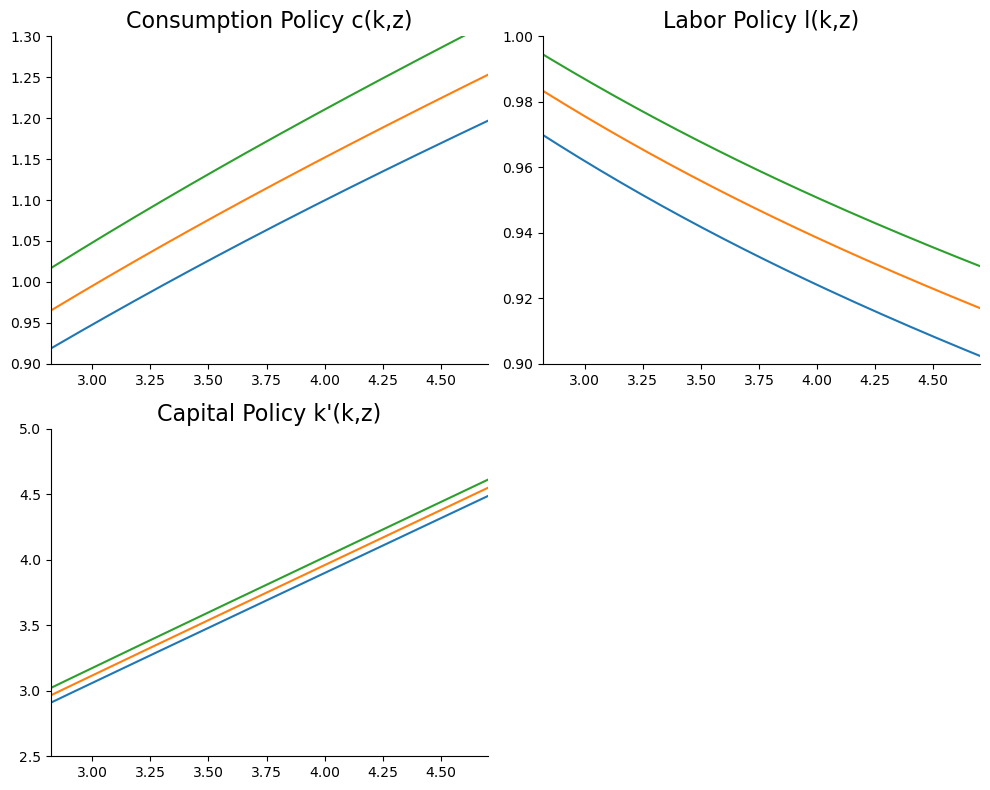

In [8]:
# Evaluate policies on CPU without gradients
with torch.no_grad():
    k_grid = torch.linspace(k_min, k_max, 200).to(device)
    # Move k_grid and z_values to CPU before converting to NumPy
    k_grid_cpu = k_grid.cpu().numpy()
    z_values_cpu = z_values.cpu().numpy()

    # Prepare input for plotting
    K, Z = torch.meshgrid(k_grid, z_values, indexing='ij')
    K_flat = K.reshape(-1)
    Z_flat = Z.reshape(-1)
    inp_plot = torch.stack((K_flat, Z_flat), dim=1)

    # Move to CPU for evaluation if networks are on GPU:
    c_net_cpu = c_net.to('cpu')
    l_net_cpu = l_net.to('cpu')
    k_net_cpu = k_net.to('cpu')
    inp_plot_cpu = inp_plot.to('cpu')

    c_plot = torch.exp(c_net_cpu(inp_plot_cpu).squeeze()).reshape(200, N_z)
    l_plot = torch.exp(l_net_cpu(inp_plot_cpu).squeeze()).reshape(200, N_z)
    kprime_plot = torch.exp(k_net_cpu(inp_plot_cpu).squeeze()).reshape(200, N_z)

    # Convert to NumPy arrays for plotting
    c_plot_np = c_plot.cpu().numpy()
    l_plot_np = l_plot.cpu().numpy()
    kprime_plot_np = kprime_plot.cpu().numpy()

# Plot the policy functions in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# 1. c(k,z)
ax = axes[0, 0]
for i in range(N_z):
    ax.plot(k_grid_cpu, c_plot_np[:, i], label=f"z = {z_values_cpu[i]:.3f}")
ax.set_title("Consumption Policy c(k,z)", fontsize=16, fontweight='normal')
#ax.set_xlabel("k")
#ax.set_ylabel("c(k,z)")
#ax.legend()
ax.set_xlim([2.82090445814822,4.70150743024704])
ax.set_ylim([0.9,1.3])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 2. l(k,z)
ax = axes[0, 1]
for i in range(N_z):
    ax.plot(k_grid_cpu, l_plot_np[:, i], label=f"z = {z_values_cpu[i]:.3f}")
ax.set_title("Labor Policy l(k,z)", fontsize=16, fontweight='normal')
#ax.set_xlabel("k")
#ax.set_ylabel("l(k,z)")
#ax.legend()
ax.set_xlim([2.82090445814822,4.70150743024704])
ax.set_ylim([0.9,1.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 3. k'(k,z)
ax = axes[1, 0]
for i in range(N_z):
    ax.plot(k_grid_cpu, kprime_plot_np[:, i], label=f"z = {z_values_cpu[i]:.3f}")
ax.set_title("Capital Policy k'(k,z)", fontsize=16, fontweight='normal')
#ax.set_xlabel("k")
#ax.set_ylabel("k'(k,z)")
#ax.legend()
ax.set_xlim([2.82090445814822,4.70150743024704])
ax.set_ylim([2.5,5.0])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 4. Empty subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

C:\Users\Howard You\AppData\Local\Temp\ipykernel_34212\54178552.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


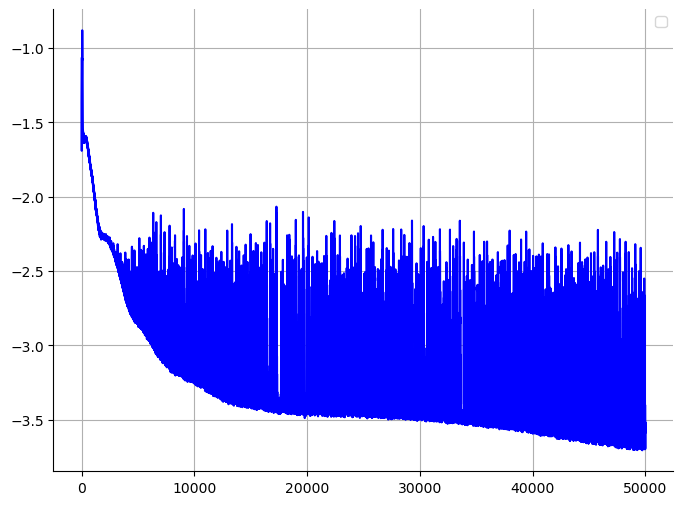

In [13]:
# Plot the Euler error history in a separate figure
eps_ee_history_np = np.log10(np.array(eps_ee_history)) # ensure it's a numpy array

plt.figure(figsize=(8, 6))
plt.plot(eps_ee_history_np, color='b')
plt.grid(True)
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

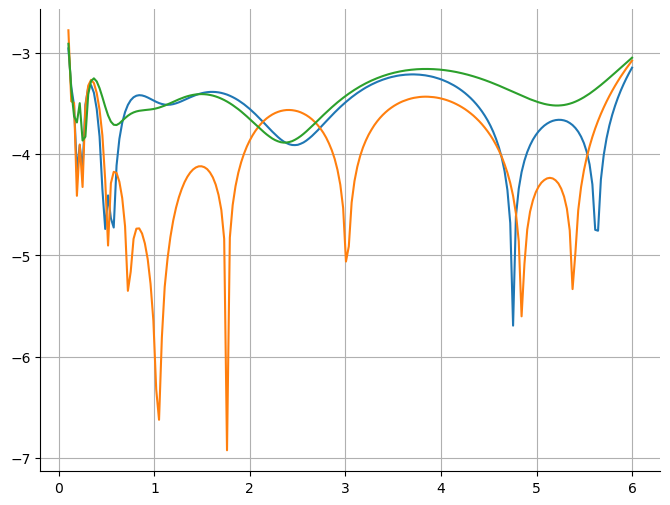

In [14]:
# Plot the Euler error against k for a given z (under final policy functions)

device = torch.device('cpu')

def compute_euler_error(k, z):
    """
    Compute the Euler error epsilon_EE(k,z) using the trained networks.
    Returns a tensor of shape [len(k)] with the Euler error values.
    """
    inp = torch.stack((k, z), dim=1)
    
    # Compute c, l, k' from the networks (assuming exponentiate to enforce positivity)
    c_val = torch.exp(c_net(inp).squeeze())
    l_val = torch.exp(l_net(inp).squeeze())
    k_val = torch.exp(k_net(inp).squeeze())
    
    eps_ee = epsilon_EE(k, z, c_val, l_val, k_val)  # shape [len(k)]
    return eps_ee


# 1. Create a grid of k-values
k_min, k_max = 0.1, 6.0
num_k_points = 200
k_grid = torch.linspace(k_min, k_max, num_k_points, device=device)

# 2. Plot log10(|eps_ee|) for each z
plt.figure(figsize=(8, 6))

for z_val in z_values:
    # Make a tensor of shape [num_k_points] filled with z_val
    z_tensor = torch.full((num_k_points,), z_val, device=device)
    
    # Compute the Euler error
    eps_ee_values = compute_euler_error(k_grid, z_tensor)  # shape [num_k_points]

    # Convert to CPU numpy for plotting
    eps_ee_np = eps_ee_values.detach().cpu().numpy()
    k_grid_np = k_grid.detach().cpu().numpy()
    
    # Take log10 of the absolute Euler error (avoid log(0) if needed)
    eps_ee_log = np.log10(np.abs(eps_ee_np) + 1e-12)

    # Plot
    plt.plot(k_grid_np, eps_ee_log, label=f"z = {z_val.item():.3f}")

#plt.title("Log10 Euler Error")
#plt.xlabel("k")
#plt.ylabel("log10(|eps_ee|)")
#plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(True)
plt.show()
